### Install Keras Tuner

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 71kB 8.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=6109b5da63f37ccebf76e8dea2659c611b99fa0e693f3746373a42e82d3be0e0
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=3b07bd67e9d20ce750b1390944c8a4e19311269612a94efdbc88fce16ea02b36
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


### Import required Libraries


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
print(tf.__version__)

2.4.1


### Load Data

In [ ]:
(train_images, train_labels),(test_images, test_labels)= fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images= train_images/255.0
test_images= test_images/255.0

In [ ]:
train_images= train_images.reshape(len(train_images), 28, 28,1)
test_images= test_images.reshape(len(test_images), 28, 28,1)

In [ ]:
train_images.shape

(60000, 28, 28, 1)

### Hyperparameter tuning

To perform hyperparameter tuning, we need to define the search space, that is to say which hyperparameters need to be optimized and in what range. Here, for this relatively small model, there are already hyperparameters that can be tuned:
1. Dropout rate
2. Number of filters for the convolutional layers
3. Number of units for the dense layer
4. Corresponding activation function

In [ ]:
def build_model(hp):
    model= keras.Sequential()
    model.add(
        Conv2D(
            filters=16,
            kernel_size=3,
            activation="relu",
            input_shape=(28,28,1),
        )
    )
    model.add(Conv2D(filters=16, activation="relu", kernel_size=3))
    model.add(MaxPooling2D(pool_size=2))
    model.add(
        Dropout(
            rate=hp.Float(
                "dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
            )
        )
    )
    model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
    model.add(
        Conv2D(
            filters=hp.Choice("num_filters", values=[32, 64], default=64,),
            activation="relu",
            kernel_size=3,
        )
    )
    model.add(MaxPooling2D(pool_size=2))
    model.add(
        Dropout(
            rate=hp.Float(
                "dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05,
            )
        )
    )
    model.add(Flatten())
    model.add(
        Dense(
            units=hp.Int(
                "units", min_value=32, max_value=512, step=32, default=128
            ),
            activation=hp.Choice(
                "dense_activation",
                values=["relu", "tanh", "sigmoid"],
                default="relu",
            ),
        )
    )
    model.add(
        Dropout(
            rate=hp.Float(
                "dropout_3", min_value=0.0, max_value=0.5, default=0.25, step=0.05
            )
        )
    )
    model.add(Dense(10, activation="softmax"))
        
        
  
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

### Random Search to find best hyperparameters

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner_search= RandomSearch(build_model,
                           objective='val_accuracy',
                           max_trials=5,
                           directory='output',
                           project_name='mnist_fashion'
                          )

INFO:tensorflow:Reloading Oracle from existing project output/mnist_fashion/oracle.json
INFO:tensorflow:Reloading Tuner from output/mnist_fashion/tuner0.json


In [ ]:
tuner_search.search(train_images, train_labels, epochs=10, validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


### Best Hyperparameters Determined

In [ ]:
tuner_search.results_summary()

Results summary
Results in output/mnist_fashion
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout_1: 0.35000000000000003
num_filters: 64
dropout_2: 0.05
units: 448
dense_activation: sigmoid
dropout_3: 0.2
learning_rate: 0.001
Score: 0.9171666502952576
Trial summary
Hyperparameters:
dropout_1: 0.5
num_filters: 32
dropout_2: 0.1
units: 416
dense_activation: relu
dropout_3: 0.2
learning_rate: 0.001
Score: 0.9153333306312561
Trial summary
Hyperparameters:
dropout_1: 0.05
num_filters: 64
dropout_2: 0.15000000000000002
units: 384
dense_activation: relu
dropout_3: 0.05
learning_rate: 0.0001
Score: 0.902999997138977
Trial summary
Hyperparameters:
dropout_1: 0.35000000000000003
num_filters: 32
dropout_2: 0.35000000000000003
units: 448
dense_activation: sigmoid
dropout_3: 0.30000000000000004
learning_rate: 0.0001
Score: 0.8648333549499512
Trial summary
Hyperparameters:
dropout_1: 0.45
num_filters: 32
dropout_2: 0.1
units: 320
dense_acti

In [ ]:
model= tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [ ]:
history= model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

### Make Predictions

In [ ]:
predictions= model.predict(test_images)

### Visualize the prediction

Actual_label : 9
Predicted_label : 9


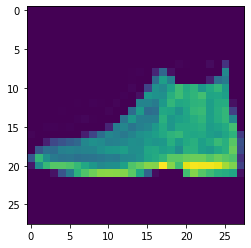

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(test_images[0].reshape(28,28))
print('Actual_label :', test_labels[0])
print('Predicted_label :', np.argmax(predictions[0]))

Actual_label : 4
Predicted_label : 4


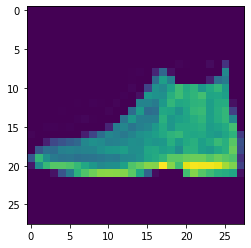

In [ ]:
plt.imshow(test_images[0].reshape(28,28))
print('Actual_label :', test_labels[10])
print('Predicted_label :', np.argmax(predictions[10]))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()